<h1><center> SR2I 208 : Stéganographie </center></h1>

<h2><center> Implementation de la méthode LSB pour cacher un message textuel dans une image </center></h2>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import binascii
from scipy.ndimage import imread

** on charge et on affiche une image **

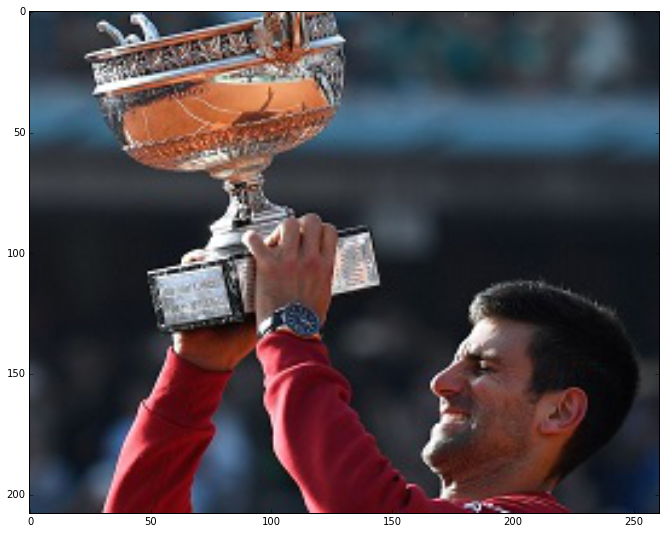

In [2]:
image = imread('djoko2.jpg')
plt.figure(figsize=(15,9))
plt.imshow(image)
plt.show()

** fonctions de décompositions et recomposition **

Il est plus simple de traiter des vecteurs que des matrices.<br>
En ce sens, il est utile de coder une fonction qui decompose les trois matrices RGB en un seul vecteur, ainsi qu'une fonction qui réassemble un tel vecteur en les trois matrices RGB

In [3]:
def decompose(image):
    image_R = image[:,:,0].ravel()
    image_G = image[:,:,1].ravel()
    image_B = image[:,:,2].ravel()
    
    return np.hstack((image_R,image_G,image_B))

def imageRecompose(imageVectorized,imageInitiale):
    
    shape = imageInitiale[:,:,0].shape
    length = len(imageVectorized)/3
    image_R = imageVectorized[0:length].reshape(shape)
    image_G = imageVectorized[length:2*length].reshape(shape)
    image_B = imageVectorized[2*length:].reshape(shape)
    
    
    image = imageInitiale.copy()
    image[:,:,0] = image_R
    image[:,:,1] = image_G
    image[:,:,2] = image_B  
    
    return image

** convertion binaire - chaîne de caractères **

Il est nécéssaire pour la suite d'avoir implémenté 
- une fonction convertissant du texte en binaire (pour cacher le message)
- une fonction convertissant un nombre binaire en texte (pour extraire le message codée de l'image stéganographiée)

In [4]:
def textToBin(text):
    string = ''
    for char in text:
        binString = bin(int(binascii.hexlify(char), 16))[2:]
        while len(binString)<8:
            binString = '0'+binString
        string += binString
        
    return string

def binToText(binaryString):
    octet = binaryString[0:8]
    binaryString = binaryString[8:]
    n = int(octet,2)
    
    if len(binaryString) >=8 :
        add = binToText(binaryString)
        return binascii.unhexlify('%x' % n)+add
    else:
        return binascii.unhexlify('%x' % n)

** fonctions manipulant les bits de poids faibles **

Trois fonctions sont utilisées sur les bits de poids faibles.
- une fonction qui met à 0 tous les LSB (clearLSB)
- une fonction qui remplace les LSB choisis par les bits du message à cacher (hideText)
- une fonction qui récupère les LSB d'une image stéganographiée pour reconstituer le message (extractMessage)

In [5]:
def clearLSB(array):
    for index,color in enumerate(array):
        if color%2==1:
            array[index]-=1
    return array

def hideText(imageDeco,texte):
    if len(imageDeco)/8 < len(texte):
        raise Warning("texte trop long pour l'image")
        return
    
    binary = textToBin(texte)
    binary +='00000000'
    for i in range(len(binary)/8):
        octet = binary[i*8:i*8+8]
        for index,byte in enumerate(octet):
            if int(byte) == 1:
                imageDeco[8*i+index]+=1
    
    return imageDeco

def extractMessage(imageDeco):
    n_octet = len(imageDeco)/8
    binaryString=''
    for i in range(n_octet):
        octet =''
        for j in range(8):
            if imageDeco[i*8+j]%2==0:
                octet+='0'
            else:
                octet+='1'
        #print 'octet:',octet
        if octet != '00000000':
            binaryString+=octet
        
        else:
            #print 'OCTET DE FIN'
            break
    #print binaryString
    #print len(binaryString)
    return binToText(binaryString)

** fonctions finales **

A l'aide des fonctions précédentes, on code des fonctions permettant de :
- cacher un texte dans une image, et retourner l'image stéganographiée (stegano)
- recupérer un message caché dans une image stéganographiée (getMessage)

In [6]:
def stegano(image,text):
    imageVectorized = decompose(image)
    image_clear = clearLSB(imageVectorized)
    image_input= hideText(image_clear,text)
    return imageRecompose(image_input,image)

In [7]:
def getMessage(image_steg):
    print 'Message decoding ...'
    imageVectorized = decompose(image_steg)
    print 'message decoded :\n',extractMessage(imageVectorized)

## Test

On cache le message 'Mon code de carte bleue: 9831' dans l'image du début

In [8]:
image_steg = stegano(image,'Mon code de carte bleue: 9831')

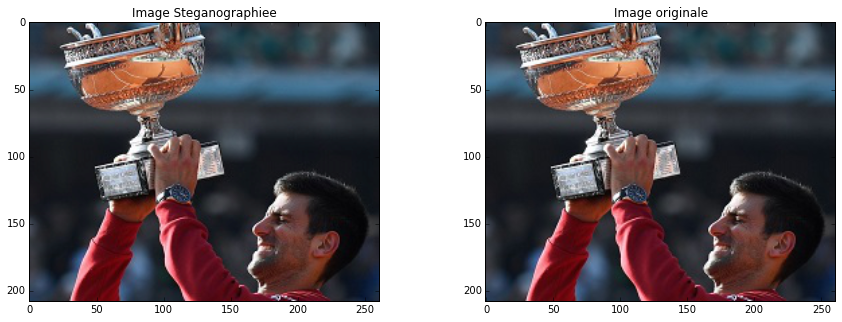

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(image_steg)
plt.title('Image Steganographiee')
plt.subplot(1,2,2)
plt.imshow(image)
plt.title('Image originale')
plt.show()

On ne voit pas la différence entre les deux images à l'oeil nu !

** Déchiffrons le message de l'image stéganographiée **

In [10]:
getMessage(image_steg)

Message decoding ...
message decoded :
Mon code de carte bleue: 9831


<br>
Le message décodé est bien le bon. Cela fonctionne !